In [9]:
import pennylane as qml
from pennylane import numpy as np
import matplotlib.pyplot as plt
from hep_VQAE import data_preprocessing as dp
import tensorflow as tf
from pennylane.optimize import AdamOptimizer, GradientDescentOptimizer
import time

import warnings
warnings.filterwarnings('ignore')

In [10]:
DATA_QBITS = 4
LATENT_QBITS = 2
TRASH_QBITS = DATA_QBITS - LATENT_QBITS
TOTAL_QBITS = DATA_QBITS + TRASH_QBITS + 1

In [11]:
dev1 = qml.device('default.qubit', wires=TOTAL_QBITS)

In [12]:
def layer(params, wires):
    for i in range(len(wires)):
        qml.RY(params[i], wires=i)
    for i in range(len(wires)):
        for j in range(i+1, len(wires)):
            qml.CNOT(wires=[i, j])

@qml.qnode(dev1)
def circuit(enc_params, data):
    qml.AngleEmbedding(data, wires=range(DATA_QBITS))
    qml.BasicEntanglerLayers(enc_params, wires=range(DATA_QBITS))
    qml.Hadamard(wires=TOTAL_QBITS-1)
    for i in range(TRASH_QBITS):
        #c += cirq.ControlledGate(sub_gate=cirq.SWAP, num_controls=1).on(swap_qbit, reference_qbits[i], network_qbits[num_data_qbits - num_latent_qbits:][i])
        qml.CSWAP(wires=[TOTAL_QBITS - 1, LATENT_QBITS + i, DATA_QBITS + i])
    qml.Hadamard(wires=TOTAL_QBITS-1)
    return qml.expval(qml.PauliZ(TOTAL_QBITS-1))

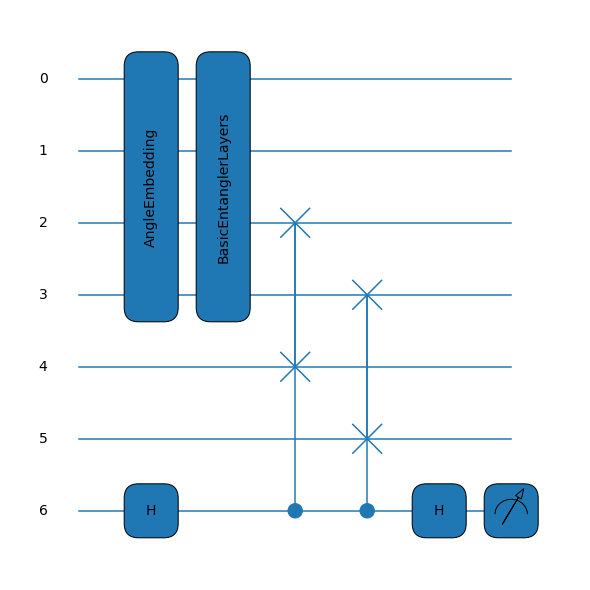

In [13]:
fig, ax = qml.draw_mpl(circuit)([[1,1,1,1]],[0.1,0.24,0.3,0.14])
fig.show()

In [14]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train, x_test = x_train/255.0, x_test/255.0

In [15]:
def filter_36(x, y):
    keep = (y == 3) | (y == 6)
    x, y = x[keep], y[keep]
    y = y == 3
    return x,y

x_train, y_train = filter_36(x_train, y_train)
x_test, y_test = filter_36(x_test, y_test)

In [16]:
DOWNSCALE = 2
DATA_DIMENSION = DOWNSCALE*DOWNSCALE
LATENT_BITS = 2

x_train, x_test = dp.PCA_reduce(x_train, DATA_DIMENSION, val_data=x_test)

In [17]:
x_train_threes = np.array(x_train[y_train==True])
x_train = np.array(x_train[y_train==False])

x_test_threes = np.array(x_test[y_test==True])
x_test = np.array(x_test[y_test==False])

In [27]:
LAYERS = 5

def cost(params, X):
    loss = 0.0
    for i in range(len(X)):
        f = circuit(params, X[i])
        loss = loss + (1 - f) ** 2
    return loss / len(X)

In [28]:
def iterate_minibatches(data, batch_size):
    for start_idx in range(0, data.shape[0] - batch_size + 1, batch_size):
        idxs = slice(start_idx, start_idx + batch_size)
        yield data[idxs]

In [29]:
learning_rate = 0.1
epochs = 2
batch_size = 64

In [30]:
# opt = AdamOptimizer(learning_rate, beta1=0.9, beta2=0.999)
# opt = qml.QNGOptimizer(learning_rate)
opt = GradientDescentOptimizer(learning_rate)

In [34]:
weight_shapes = {"weights": (LAYERS, DATA_QBITS)}
params = np.random.uniform(size=weight_shapes["weights"], requires_grad=True)

In [35]:
params.shape

(5, 4)

In [36]:
start = time.time()

for it in range(epochs):
    for j,Xbatch in enumerate(iterate_minibatches(x_train, batch_size=batch_size)):
        params, _ = opt.step(cost, params, Xbatch)
        print(j, end="\r")

    loss = cost(params, x_train)
    
    print(f"Epoch: {it} | Loss: {loss} |")
    
end = time.time()

print(f"Time for {epochs} epochs with {LAYERS} layers: {end - start}")

Epoch: 0 | Loss: 0.003740733980875299 |
Epoch: 1 | Loss: 0.0014238816413360486 |
Time for 2 epochs with 5 layers: 588.6051685810089
